In [1]:
# Regular packages
import pandas as pd
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore") # might not be the best idea

In [2]:
# pyspark packages 
from pyspark.sql.functions import col, concat, collect_list,struct
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from pyspark.sql.functions import udf, array, array_distinct, array_min,array_max,array_union, explode
from pyspark.sql.types import IntegerType, DoubleType, ArrayType

from pyspark import SparkContext
from pyspark.sql import Row

## Analysis of RDD 

In [3]:
def file_to_rdd(file):
    """
    This function takes a file name and converts it into an RDD.
    
    Arguments:
    file (str): file name
    
    Returns:
    An RDD containing all information extracted from the file.
    """

    if file[-3:] == "csv" : 
        data = spark.read.format("csv").option("inferSchema", "true")\
                                        .option("delimiter", ',')\
                                        .option("header", 'true')\
                                        .load(file).cache()

        rdd = adj_cache.rdd.map(tuple)
        return rdd
    elif file[-3:] == "txt" : 
        rdd_web = sc.textFile(file) \
                    .map(lambda line: line.split('\t')) \
                    .filter(lambda line: len(line)>1) \
                        .map(lambda line: (line[0],line[1]))

        return rdd_web

In [5]:
sc = SparkContext()

In [6]:
spark = SparkSession.builder.appName('abc').getOrCreate()

In [6]:
#First try with the example of the research paper 

from pyspark import SparkContext

time1 = time.time()

graph = sc.parallelize([(0, 1), (1, 2), (1, 3), (3, 4), (5, 6), (6, 7)])
counter_new_pair = sc.accumulator(1)

def reducer(node):
    minimum = node[0]
    value_List = []
    joined = []
  
    for value in node[1]:
        if value<minimum:
            minimum = value
        value_List.append(value)
    if minimum<node[0]:
        joined.append((node[0],minimum))
        for value in value_List:
            if minimum != value:
                counter_new_pair.add(1)
                joined.append((value, minimum))
    return joined

while counter_new_pair.value > 0:
    counter_new_pair = sc.accumulator(0)

    #CCF-Iterate
    mapping_1 = graph.map(lambda node : (node[0], node[1]))
    mapping_2 = graph.map(lambda node : (node[1], node[0]))
    fusion = mapping_1.union(mapping_2)
    fusion = fusion.groupByKey().map(lambda node : (node[0], list(node[1])))
    joined = fusion.flatMap(lambda node: reducer(node))
    # CCF-Dedup
    graph = joined.map(lambda node : ((node[0], node[1]), None)).groupByKey()
    graph = graph.map(lambda x: (x[0][0], x[0][1]))
    graph.collect()
  
    print("counter: ", counter_new_pair)
  
    graph.collect()
    
time2 = time.time()

print("It took {:.3f} seconds".format(time2-time1))

counter:  4
counter:  9
counter:  4
counter:  0
It took 7.684 seconds


In [ ]:
#Let's try with the Google Graph 

web_google = sc.textFile("web-Google 2.txt")\
                    .map(lambda line: line.split('\t')) \
                    .filter(lambda line: len(line)>1) \
                        .map(lambda line: (line[0],line[1]))

graph = web_google

time1 = time.time()

counter_new_pair = sc.accumulator(1)

def reducer(node):
    minimum = node[0]
    value_List = []
    joined = []
  
    for value in node[1]:
        if value<minimum:
            minimum = value
        value_List.append(value)
    if minimum<node[0]:
        joined.append((node[0],minimum))
        for value in value_List:
            if minimum != value:
                counter_new_pair.add(1)
                joined.append((value, minimum))
    return joined

while counter_new_pair.value > 0:
    counter_new_pair = sc.accumulator(0)

    #CCF-Iterate
    mapping_1 = graph.map(lambda node : (node[0], node[1]))
    mapping_2 = graph.map(lambda node : (node[1], node[0]))
    fusion = mapping_1.union(mapping_2)
    fusion = fusion.groupByKey().map(lambda node : (node[0], list(node[1])))
    joined = fusion.flatMap(lambda node: reducer(node))
    # CCF-Dedup
    graph = joined.map(lambda node : ((node[0], node[1]), None)).groupByKey()
    graph = graph.map(lambda x: (x[0][0], x[0][1]))
    graph.collect()
  
    print("counter: ", counter_new_pair)
    
time2 = time.time()

print("It took {:.3f} seconds".format(time2-time1))

In [ ]:
# Comparison according to graph size 

values = [len(web_google.collect())//(10-i) for i in range(1, 10)]

time_ = []

for i in range(len(values)):
    graph = sc.parallelize(web_google.collect()[1:values[i]])
    
    time1 = time.time()
    
    counter_new_pair = sc.accumulator(1)
    
    while counter_new_pair.value > 0:
        
        counter_new_pair = sc.accumulator(0)

        #CCF-Iterate
        mapping_1 = graph.map(lambda node : (node[0], node[1]))
        mapping_2 = graph.map(lambda node : (node[1], node[0]))
        fusion = mapping_1.union(mapping_2)
        fusion = fusion.groupByKey().map(lambda node : (node[0], list(node[1])))
        joined = fusion.flatMap(lambda node: reducer(node))
        # CCF-Dedup
        graph = joined.map(lambda node : ((node[0], node[1]), None)).groupByKey()
        graph = graph.map(lambda x: (x[0][0], x[0][1]))
        graph.collect()
    
    time2 = time.time()
    
    time_.append((i, time2-time1))

In [ ]:
plt.figure(figsize=(10, 8))
plt.title("Speed (in seconds) relatively to the % of the graph taken")
plt.plot([time_[i][1] for i in range(len(time_))]);

## Try part, Dataframe

In [10]:
df = spark.read.format("csv").option("inferSchema", "true")\
                                        .option("delimiter", ',')\
                                        .option("header", 'true')\
                                        .load("web-Google_500000.csv").toDF("val","key").cache()

In [11]:
df.show()

+------+------+
|   val|   key|
+------+------+
|     0|867923|
|     0|891835|
| 11342|     0|
| 11342| 27469|
| 11342| 38716|
| 11342|309564|
| 11342|322178|
| 11342|387543|
| 11342|427436|
| 11342|538214|
| 11342|638706|
| 11342|645018|
| 11342|835220|
| 11342|856657|
| 11342|867923|
| 11342|891835|
|824020|     0|
|824020| 91807|
|824020|322178|
|824020|387543|
+------+------+
only showing top 20 rows



In [12]:
import pyspark
from pyspark.sql import Window
from pyspark.sql.functions import *

def ccf_iterate_map_df(df):
    newRow = df.select("val", "key")
    df1 = df.union(newRow)
    return df1

def ccf_iterate_reduce_df(df1):
    window = Window.orderBy("key","val").partitionBy("key")
    df_min = df1.withColumn("min", min("val").over(window))

    new_column_1 = expr( """IF(min > key, Null, IF(min = val, key, val))""")
    new_column_2 = expr("""IF(min > key, Null, min)""")
    new_df = (df_min
      .withColumn("new_key", new_column_1)
      .withColumn("new_val", new_column_2)) \
    .na.drop() \
    .select(col("new_key").alias("key"), col("new_val").alias("val")) \
    .sort("val", "key") 
        
    df2 = new_df.distinct()
    
    return df2, df_min


import time

begin = time.time()
counter = sc.accumulator(1)
iteration = 0
while counter!=0:
    counter = sc.accumulator(1)
    iteration +=1
    df1 = ccf_iterate_map_df(df)
    df.unpersist()
    df, df_counter = ccf_iterate_reduce_df(df1)
    df1.unpersist()
    df_counter = df_counter.withColumn("counter_col", expr("""IF(min > key, 0, IF(min = val, 0, 1))"""))
    counter = sc.accumulator(df_counter.select(sum("counter_col")).collect()[0][0])
    print(counter)
    
end = time.time()

645720
188263
249888
326246
252536
73441
518
0
0


KeyboardInterrupt: 

In [ ]:
print(end-begin)

In [ ]:
names = ["web-Google_500000.csv", "web-Google_1000000.csv", "web-Google_1500000.csv", "web-Google_2000000.csv", "web-Google_2500000.csv", "web-Google_3000000.csv", "web-Google_3500000.csv", "web-Google_4000000.csv", "web-Google_total.csv"]

liste = []
for i in names:
    df = spark.read.format("csv").option("inferSchema", "true")\
                                        .option("delimiter", ',')\
                                        .option("header", 'true')\
                                        .load(i).toDF("val","key").cache()
    begin = time.time()
    counter = 1
    iteration = 0
    while counter!=0:
        iteration +=1
        df1 = ccf_iterate_map_df(df)
        df, df_counter = ccf_iterate_reduce_df(df1)
        df_counter = df_counter.withColumn("counter_col", expr("""IF(min > key, 0, IF(min = val, 0, 1))"""))
        counter = df_counter.select(sum("counter_col")).collect()[0][0]
        print(counter)
    
    end = time.time()
    print((i, end-begin))
    liste.append((i, end-begin))

645720
188263
249888
326246
252536
73441
518
0
('web-Google_500000.csv', 596.3252799510956)
1379336
411275
466760
634325
483907
133761
1344
0
('web-Google_1000000.csv', 572.8978681564331)
2158798
651571
663595
916646
680213
154277
1966
0
('web-Google_1500000.csv', 967.4510378837585)
2965172
912104
846662
1189233
876542
174605
2038
0
('web-Google_2000000.csv', 597.5754508972168)
3789920
1184366
1023125
1451456
1057318
205858
2436
0
('web-Google_2500000.csv', 3045.270040988922)
4630528
1479228
1199555
1712234
1248788
214513
3162
0
('web-Google_3000000.csv', 622.9565620422363)
5483928
1785818
1373705
1981569
1446347


## Analysis of Dataframes

In [13]:
#First, let's define our function to import and analyze Dataframes

def our_union (x):
    x[1].append(x[0])
    return x[1]

our_union_udf = f.udf(our_union, ArrayType(IntegerType()))
findmin = f.udf(lambda x: min(x), IntegerType())
our_distinct = f.udf(lambda x: list(set(x)), ArrayType(IntegerType()))

def CCF_DEDUP_df(df):
    
    reverseDF = df.select(col("From").alias("To"),col("To").alias("From"))
    df_0 = df.union(reverseDF)
    
    df_1 = df_0.groupBy(col("To")).agg(our_distinct(collect_list(col("From"))).alias('From'))
    df_2 = df_1.withColumn('From', our_union_udf(struct(df_1.To, df_1.From)))\
                    .withColumn('To', findmin("From"))\
                        .withColumn('From', our_distinct('From'))
    
    df_3 = df_2.select( explode(col("From")).alias("To"), col("To").alias("From")).dropDuplicates()
    
    return df_3

def Analyze(df):
    
    reverseDF = df.select(col("From").alias("To"),col("To").alias("From"))
    df_0 = df.union(reverseDF)
      
    size = df_0.distinct().count()/2

    t = time.time()
    
    counter = sc.accumulator(0)
    while df.count()!= df.select('To').distinct().count() :
        counter.add(1)
        df = CCF_DEDUP_df(df) 
    t = time.time() - t
    
    #Getting the number of groups of connected components
    num_of_groups = len(df.select('From').distinct().collect())
    
    return t, size,num_of_groups, counter,  df

In [18]:
df = spark.read.format("csv").option("inferSchema", "true")\
                                        .option("delimiter", ',')\
                                        .option("header", 'true')\
                                        .load("web-Google_total.csv").toDF("From","To").cache()

In [19]:
Analyze(df)

PythonException: 
  An exception was thrown from the Python worker. Please see the stack trace below.
Traceback (most recent call last):
  File "/Users/hippolyteguigon/opt/anaconda3/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 604, in main
    process()
  File "/Users/hippolyteguigon/opt/anaconda3/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 596, in process
    serializer.dump_stream(out_iter, outfile)
  File "/Users/hippolyteguigon/opt/anaconda3/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 211, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "/Users/hippolyteguigon/opt/anaconda3/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 132, in dump_stream
    for obj in iterator:
  File "/Users/hippolyteguigon/opt/anaconda3/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 200, in _batched
    for item in iterator:
  File "/Users/hippolyteguigon/opt/anaconda3/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 450, in mapper
    result = tuple(f(*[a[o] for o in arg_offsets]) for (arg_offsets, f) in udfs)
  File "/Users/hippolyteguigon/opt/anaconda3/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 450, in <genexpr>
    result = tuple(f(*[a[o] for o in arg_offsets]) for (arg_offsets, f) in udfs)
  File "/Users/hippolyteguigon/opt/anaconda3/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 85, in <lambda>
    return lambda *a: f(*a)
  File "/Users/hippolyteguigon/opt/anaconda3/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 73, in wrapper
    return f(*args, **kwargs)
  File "/Users/hippolyteguigon/opt/anaconda3/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 77, in <lambda>
    return lambda *a: g(f(*a))
  File "<ipython-input-13-8bc29344e622>", line 8, in <lambda>
  File "/Users/hippolyteguigon/opt/anaconda3/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/sql/functions.py", line 168, in min
    return _invoke_function_over_column("min", col)
  File "/Users/hippolyteguigon/opt/anaconda3/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/sql/functions.py", line 66, in _invoke_function_over_column
    return _invoke_function(name, _to_java_column(col))
  File "/Users/hippolyteguigon/opt/anaconda3/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/sql/column.py", line 45, in _to_java_column
    raise TypeError(
TypeError: Invalid argument, not a string or column: [914056, 102669, 80527, 29338, 759848, 593321, 109485, 801074, 911165, 382911, 906432, 683587, 17093, 265669, 809163, 224718, 357073, 909528, 105956, 302564, 302064, 702328, 622842, 43515, 444796, 85] of type <class 'list'>. For column literals, use 'lit', 'array', 'struct' or 'create_map' function.


In [20]:
df.show()

+------+------+
|  From|    To|
+------+------+
|     0|867923|
|     0|891835|
| 11342|     0|
| 11342| 27469|
| 11342| 38716|
| 11342|309564|
| 11342|322178|
| 11342|387543|
| 11342|427436|
| 11342|538214|
| 11342|638706|
| 11342|645018|
| 11342|835220|
| 11342|856657|
| 11342|867923|
| 11342|891835|
|824020|     0|
|824020| 91807|
|824020|322178|
|824020|387543|
+------+------+
only showing top 20 rows



## RDD vs Dataframe

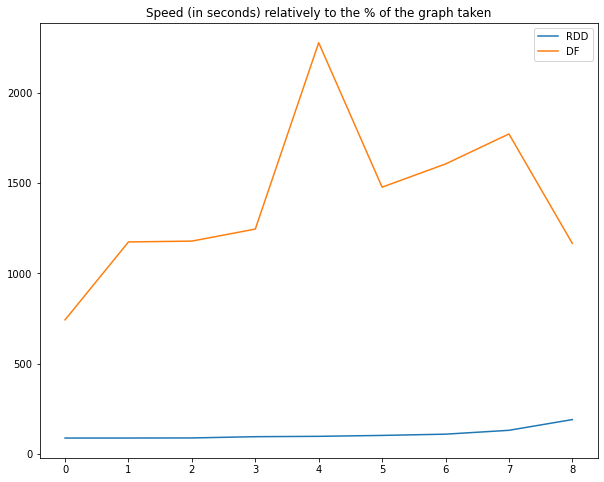

In [22]:
plt.figure(figsize=(10, 8))
plt.title("Speed (in seconds) relatively to the % of the graph taken")
plt.plot([time_[i][1] for i in range(len(time_))], label="RDD")
plt.plot([time_df[i] for i in range(len(time_df))], label="DF")
plt.legend()
plt.show();